In [136]:
import rank_histograms as rh
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import xskillscore as xs
import numpy as np
from string import ascii_lowercase, ascii_uppercase
import pandas as pd
import xarray as xr
import bias_spread as bs


In [ ]:
filename =  'CanESM5': 'CMIP.CCCma.CanESM5.historical.day.gn_moments@10and50and100hPa.nc'

In [ ]:
plt.text()

In [128]:


def plot_roc(ax,roc,model,event_type='split'):
    false_positive=roc.sel(metric='false positive rate')
    true_positive=roc.sel(metric='true positive rate')
    #roc.to_dataset(dim='metric').plot.line(y='true positive rate', x='false positive rate')
    #roc.to_dataset(dim='metric').plot.plot(y='true positive rate', x='false positive rate')
    ax.plot(false_positive, true_positive,'o-')
    ax.fill_between(false_positive, true_positive, alpha = 0.3)
    
    #ax.set_xlabel('false positive rate')
    if event_type == 'split':
        ax.set_ylabel('')
    else:
        ax.set_ylabel('true positive rate')
    area=roc.sel(metric='area under curve').values[0]
    ax.plot([0, 1], [0, 1], 'k:')
    #ax.text(0.5,1.08,'ROC curve '+event_type+' events '+model,fontsize=12,ha='center',transform=ax.transAxes)
    ax.text(0.67,0.2,'AUC='+str(round(area,2)),ha='center', color = 'C0',fontweight='bold')#,transform=ax.transAxes)
    ax.set_title(event_type,fontsize=13)

#estimate uncertainty with perfect model range
def freq_test(ds,threshold,lower=True):
    nmem=len(ds['member'])
    freq_stats=np.empty((nmem))
    for mem in range(nmem):
        observations=ds.isel(member=mem)
        if lower:
            roc_areas=roc=xs.roc(observations<threshold, (ds<threshold).mean('member'),
                   return_results='all_as_metric_dim')
        if not lower:
            roc_areas=roc=xs.roc(observations>threshold, (ds>threshold).mean('member'),
                   return_results='all_as_metric_dim')    
        area=roc.sel(metric='area under curve').values[0]
        freq_stats[mem]=area
    mean=np.mean(freq_stats[:])
    perc5=np.percentile(freq_stats[:]-mean,5)
    perc95=np.percentile(freq_stats[:]-mean,95)
    return perc5,perc95

def label_bars(roc, ax):
        """Attach a text label on top of each bar."""
        for i, pb in enumerate(roc.probability_bin):
            y = roc.sel(metric = 'true positive rate')[i]
            x = roc.sel(metric = 'false positive rate')[i]
            if (y > 0.2) & (y < 0.9) & (x > 0.2) & (x < 0.9): 
                ax.annotate(f'{pb.values.round(2)}',
                            xy=(x, y),
                            xytext=(0, 4),  # 4 points vertical offset.
                            textcoords='offset points',
                            color = 'C0',
                            alpha = 0.6,
                            ha='center', va='bottom')


obs=rh.get_dataset(rh.path_to_data+'ERA5_moments@10and50and100hPa_NHonly.nc')
obs_cl=obs['centroid_latitude'].loc['1979-01-01':'2014-12-28',1e3]
obs_ar=obs['aspect_ratio'].loc['1979-01-01':'2014-12-28',1e3]


In [26]:
area_displacements=[]
area_splits=[]
models = []

In [20]:
import warnings


In [22]:
warnings.filterwarnings("ignore")

In [60]:
forecast

<xarray.Dataset>
Dimensions:             (member: 35, time: 13300, plev: 3)
Coordinates:
  * time                (time) object '1920-01-01' '1920-01-02' ... '2014-12-28'
  * plev                (plev) float64 1e+04 5e+03 1e+03
  * member              (member) <U9 'r10i1p1f1' 'r10i1p2f1' ... 'r9i1p2f1'
Data variables:
    angle               (member, time, plev) float64 -6.53 10.81 ... -13.8
    aspect_ratio        (member, time, plev) float64 2.073 2.098 ... 1.422 1.206
    objective_area      (member, time, plev) float64 7.786e+10 ... 3.643e+11
    kurtosis            (member, time, plev) float64 0.1251 -0.05142 ... 0.3044
    centroid_latitude   (member, time, plev) float64 88.46 83.7 ... 84.2 82.32
    centroid_longitude  (member, time, plev) float64 -12.93 44.22 ... 87.99

displacement CanESM5
split CanESM5


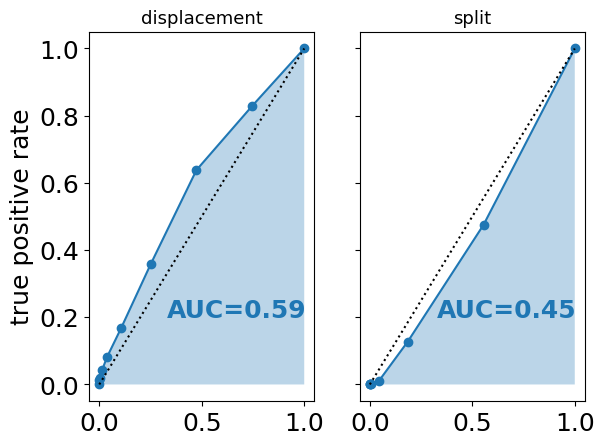

In [129]:
model = 'CanESM5' # 'CanESM2'
forecast=rh.get_dataset(rh.path_to_data+rh.file_name[model])
#define bin edges
#edges=np.arange(0,1.02,0.02)
fig, axes = plt.subplots(1,2, sharey = True)
if any(forecast['plev'].isin(1e3)):
    #roc curve for displacement
    forecast_cl=forecast['centroid_latitude'].loc[:,'1979-01-01':'2014-12-28',1e3]
    roc_d=xs.roc(obs_cl<66, (forecast_cl<66).mean('member'),return_results='all_as_metric_dim') #thresholds as in Seviour et al. 2013
    area_d=roc_d.sel(metric='area under curve').values[0]
    #use rank frequency test to produce error bars
    err_5,err_95=freq_test(forecast_cl,threshold=66,lower=True)
    area_displacements.append('{model}&{area:.3f}&{perc5:.3f}&{perc95:.3f}'.format(
        model=model,area=area,perc5=err_5,perc95=err_95))
    plt.rcParams.update({'font.size': 18})

    plot_roc(axes[0],roc_d,model,event_type='displacement')
    #axes[0].fill_between()
    # roc.to_dataset(dim='metric').plot.scatter(y='true positive rate', x='false positive rate')
    #plt.plot([0, 1], [0, 1], 'k:')
    #plt.title('ROC curve displacement events '+model)
    #plt.savefig('../plots/displacement_'+model+'.pdf', bbox_inches = 'tight')
    #plt.close()
    print('displacement',model)

    #roc curve for split
    forecast_ar=forecast['aspect_ratio'].loc[:,'1979-01-01':'2014-12-28',1e3]
    roc_s=xs.roc(obs_ar>2.4, (forecast_ar>2.4).mean('member'),return_results='all_as_metric_dim')
    area_s=roc_s.sel(metric='area under curve').values[0]
    err_5,err_95=freq_test(forecast_ar,threshold=2.4,lower=False)
    area_splits.append('{model}&{area:.3f}&{perc5:.3f}&{perc95:.3f}'.format(
        model=model,area=area,perc5=err_5,perc95=err_95))
    plot_roc(axes[1],roc_s,model)
    #plt.plot([0,1], [0, 1], 'k:')
    #plt.title('ROC curver ')
    #plt.savefig('../plots/split_'+model+'.pdf', bbox_inches = 'tight')
    #plt.close()
    models.append(model)
    print('split',model)

In [103]:
observations = (obs_ar>2.4)
forecasts = (forecast_ar>2.4).mean('member').reset_coords(drop = True)
dim = list(forecasts.dims)

f_bin = forecasts.stack(ndim=forecasts.dims)
f_bin = f_bin.sortby(-f_bin)
bin_edges = np.append(f_bin[0] + 1, f_bin)
bin_edges = np.unique(bin_edges)

tpr, fpr = [], []
for i in bin_edges:
    
    dichotomous_category_edges = np.array(
        [-np.inf, i, np.inf]
    )  # "dichotomous" means two-category
    print(dichotomous_category_edges)
    dichotomous_contingency = xs.Contingency(
        observations,
        forecasts,
        dichotomous_category_edges,
        dichotomous_category_edges,
        dim=dim,
    )
    fpr.append(dichotomous_contingency.false_alarm_rate())
    tpr.append(dichotomous_contingency.hit_rate())

[-inf   0.  inf]
[-inf 0.02  inf]
[-inf 0.04  inf]
[-inf 0.06  inf]
[-inf 0.08  inf]
[-inf  0.1  inf]
[-inf 0.12  inf]
[-inf 0.14  inf]
[-inf 0.16  inf]
[-inf 0.18  inf]
[-inf 1.18  inf]


In [106]:
tpr = xr.concat(tpr, "probability_bin")
fpr = xr.concat(fpr, "probability_bin")
tpr

<xarray.DataArray 'histogram_observations_forecasts' (probability_bin: 11)>
array([1.        , 0.88297872, 0.67375887, 0.35460993, 0.16312057,
       0.04609929, 0.0070922 , 0.        , 0.        , 0.        ,
              nan])
Dimensions without coordinates: probability_bin

In [109]:
roc_s#.sel(metric = 'true positive rate')

<xarray.DataArray 'histogram_observations_forecasts' (metric: 3,
                                                      probability_bin: 11)>
array([[0.00000000e+00, 4.20344683e-04, 1.26103405e-03, 4.41361917e-03,
        1.76544767e-02, 5.69567045e-02, 1.38503573e-01, 3.00546448e-01,
        5.66834805e-01, 8.46574191e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.09219858e-03, 4.60992908e-02, 1.63120567e-01, 3.54609929e-01,
        6.73758865e-01, 8.82978723e-01, 1.00000000e+00],
       [5.50680601e-01, 5.50680601e-01, 5.50680601e-01, 5.50680601e-01,
        5.50680601e-01, 5.50680601e-01, 5.50680601e-01, 5.50680601e-01,
        5.50680601e-01, 5.50680601e-01, 5.50680601e-01]])
Coordinates:
  * probability_bin  (probability_bin) float64 1.18 0.18 0.16 ... 0.04 0.02 0.0
    plev             float64 1e+03
  * metric           (metric) <U19 'false positive rate' ... 'area under curve'

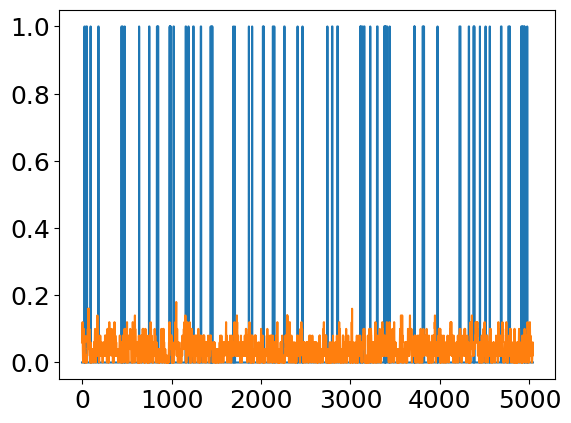

In [86]:
temp = (obs_ar>2.4)*1.
plt.plot(temp)
plt.plot())

(array([13798., 31377., 34258., 28515., 20987., 14352.,  9580.,  6469.,
         4220.,  2896.,  2084.,  1515.,  1138.,   816.,   619.,   508.,
          466.,   330.,   310.,   253.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
        2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <BarContainer object of 20 artists>)

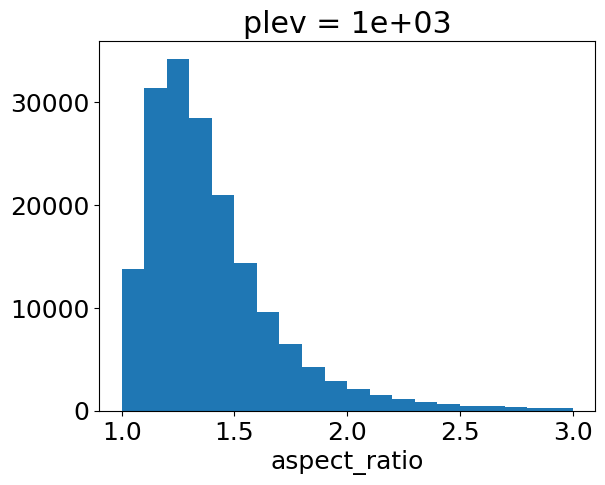

In [69]:
forecast_ar.plot.hist(bins = np.linspace(1,3,21))

(array([ 763., 1390., 1357.,  825.,  421.,  198.,   65.,   15.,    4.,
           2.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 1.18]),
 <BarContainer object of 10 artists>)

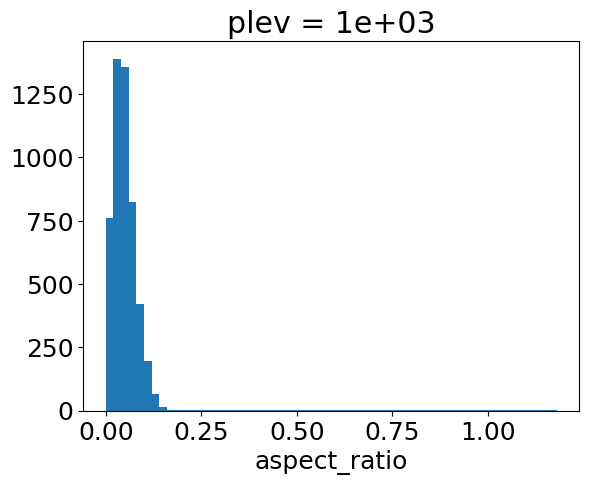

In [99]:

(forecast_ar>2.4).mean('member').plot.hist(bins = bin_edges)

(array([2.266e+03, 1.857e+03, 0.000e+00, 7.030e+02, 0.000e+00, 1.780e+02,
        2.700e+01, 0.000e+00, 8.000e+00, 1.000e+00]),
 array([0.        , 0.01714286, 0.03428571, 0.05142857, 0.06857143,
        0.08571429, 0.10285714, 0.12      , 0.13714286, 0.15428571,
        0.17142857]),
 <BarContainer object of 10 artists>)

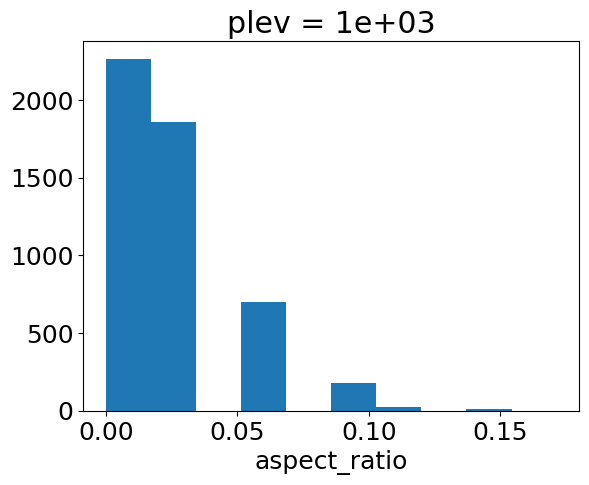

In [67]:
(forecast_ar>2.4).mean('member').plot.hist()

In [114]:
roc_s.sel(metric = 'true positive rate')[0]

<xarray.DataArray 'histogram_observations_forecasts' ()>
array(0.)
Coordinates:
    probability_bin  float64 1.18
    plev             float64 1e+03
    metric           <U19 'true positive rate'

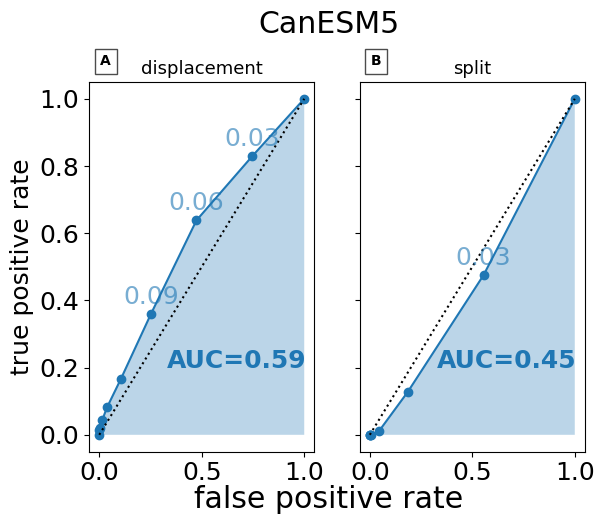

In [130]:
fig, axes = plt.subplots(1,2,sharey=True)
plot_roc(axes[0],roc_d,model,event_type='displacement')
plot_roc(axes[1],roc_s,model,event_type='split')
axes[0].text(0.05, 1.075, ascii_uppercase[0], transform=axes[0].transAxes,
                      fontsize=10, fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
axes[1].text(0.05, 1.075, ascii_uppercase[1], transform=axes[1].transAxes,
                      fontsize=10, fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
fig.supxlabel('false positive rate', y = -0.02,verticalalignment='bottom')
fig.suptitle(model, y = 1.03)


label_bars(roc_d, axes[0])
label_bars(roc_s, axes[1])

plt.savefig('ROC_example_'+model+'.pdf', bbox_inches = 'tight')

In [132]:
era_reanalysis=rh.get_dataset(rh.path_to_data+'ERA5_moments@10and50and100hPa_NHonly.nc')
vars=list(era_reanalysis.keys())
vars

['angle',
 'aspect_ratio',
 'objective_area',
 'kurtosis',
 'centroid_latitude',
 'centroid_longitude']

<xarray.DataArray 'aspect_ratio' (time: 5040)>
array([1.06396639, 1.08336642, 1.15513537, ..., 1.17706752, 1.16612916,
       1.13073937])
Coordinates:
  * time     (time) object '1979-01-01' '1979-01-02' ... '2014-12-28'
    plev     float64 1e+03

In [247]:
 var in ['aspect_ratio'] and plev == 1000

False

In [256]:
vars

['angle',
 'aspect_ratio',
 'objective_area',
 'kurtosis',
 'centroid_latitude',
 'centroid_longitude']

In [303]:
fce = lambda x: str(int(x))+" hPa"

df3_ls = []
for model in rh.file_name:
    print(model)
    forecast=rh.get_dataset(rh.path_to_data+rh.file_name[model])
    plev_str_ls = list(map(fce,forecast['plev'].values/100))
    #sys.exit()
    #plot and save rank histogram for every variable and pressure level
    df2_ls = []
    for n in range(len(forecast['plev'])):
        plev=float(forecast['plev'][n])
        df_ls = []
        for var in vars[1:]:
            rank_hist=rh.get_rank_stats(era_reanalysis,forecast,
                                var,'1979-01-01','2014-12-31',forecast['plev'][n],dim='time',member_dim='member')
            """plt.step(rank_hist['rank'],rank_hist,'r',where='mid')
            expected=np.empty(len(rank_hist))
            expected[:]=np.sum(rank_hist)/len(rank_hist)
            plt.step(rank_hist['rank'],expected,'b',where='mid')
            plt.xlim([1,len(rank_hist)])
            plt.ylim(bottom=0)
            """#calculate statistics and add them to the plot
            bias=bs.bias(rank_hist)
            spread=bs.spread(rank_hist)

            
            if var in ['aspect_ratio'] and plev == 1000:
                obs_ar = era_reanalysis['aspect_ratio'].loc['1979-01-01':'2014-12-28',1e3]
                forecast_ar=forecast['aspect_ratio'].loc[:,'1979-01-01':'2014-12-28',1e3]
                
                
                roc=xs.roc(obs_ar>2.4, (forecast_ar>2.4).mean('member'),return_results='all_as_metric_dim')
                area=roc.sel(metric='area under curve').values[0]      
                
                df = pd.DataFrame(
                    {'bias': [bias], 'spread': [spread], 'AUC': [area]}, 
                    index = pd.MultiIndex.from_product([[model], [var.replace('_', ' ')]])
                )
            elif var in ['centroid_latitude'] and plev == 1000:
                obs_cl=obs['centroid_latitude'].loc['1979-01-01':'2014-12-28',1e3]
                forecast_cl=forecast['centroid_latitude'].loc[:,'1979-01-01':'2014-12-28',1e3]
                
                roc=xs.roc(obs_cl<66, (forecast_cl<66).mean('member'),return_results='all_as_metric_dim') 
                area=roc.sel(metric='area under curve').values[0]
                
                df = pd.DataFrame(
                    {'bias': [bias], 'spread': [spread], 'AUC': [area]}, 
                    index = pd.MultiIndex.from_product([[model], [var.replace('_', ' ')]])
                )
            else:
                df = pd.DataFrame(
                    {'bias': [bias], 'spread': [spread],'AUC': [np.nan]}, 
                    index = pd.MultiIndex.from_product([[model], [var.replace('_', ' ')]])
                )
                
            df_ls.append(df)

        df2_ls.append(pd.concat(df_ls))

    temp = pd.concat(df2_ls, axis = 1)
    temp.columns=pd.MultiIndex.from_product([plev_str_ls, ['bias','spread','AUC']])

    df3_ls.append(temp)



CanESM2
CanESM5
CESM2
CNRM-CM6-1
INM-CM5-0
IPSL-CM6A-LR
MIROC6
UKESM1-0-LL
MPI-ESM1-2-HR
MPI-ESM1-2-LR
GFDL-CM3


In [304]:
df_all = pd.concat(df3_ls)#.reset_index()
df_all = df_all.replace(np.nan, '')
#df_all = df_all.replace('100.0', '100\,hPa')
df_all#.head()

100 hPa                       50 hPa  \
                                         bias       spread AUC        bias   
CanESM2       aspect ratio         590.991956   213.265864      210.741987   
              objective area       343.125869   122.475559       15.733539   
              kurtosis              11.782572   226.711966      591.698546   
              centroid latitude    418.515462    79.544978      336.711752   
              centroid longitude   118.844015    66.857357        3.128968   
CanESM5       aspect ratio         184.777762    48.573559      266.946247   
              objective area       894.648798     1.512671      1520.33009   
              kurtosis             118.641458   410.998739       16.795183   
              centroid latitude    289.995369    53.737284      276.068901   
              centroid longitude    44.198215    47.258027         1.48499   
CESM2         aspect ratio         104.882014    10.337744      271.809642   
              objective area       334.062792    91.538477      476.735609   
              kurtosis               6.817608   217.615629       61.088983   
              centroid latitude    252.673665    88.903880      366.220988   
              centroid longitude    26.310548    50.333578        0.005806   
CNRM-CM6-1    aspect ratio           6.744165     0.717461       14.666975   
              objective area         3.001583     5.459485       51.572609   
              kurtosis             227.266143    10.947593      866.917085   
              centroid latitude      0.064103     2.240237        22.69243   
              centroid longitude     0.393802     4.149227       15.796974   
INM-CM5-0     aspect ratio         257.000020    69.240144      119.676391   
              objective area        26.652401    71.305700       71.702401   
              kurtosis              52.264464   221.071573      114.181419   
              centroid latitude    304.266984   182.845369      391.941196   
              centroid longitude    55.004464    53.036744        0.033406   
IPSL-CM6A-LR  aspect ratio          41.733826     4.267439      115.304717   
              objective area       507.800002    75.514577      137.372919   
              kurtosis               1.260681    94.650421       10.647187   
              centroid latitude     44.413132    18.485090       64.222584   
              centroid longitude    77.083826    41.454719        3.294524   
MIROC6        aspect ratio           8.382937     7.858433        6.055326   
              objective area       841.650179   420.276898      900.004464   
              kurtosis              62.653353     0.384425       19.477345   
              centroid latitude      0.164306    19.326053       97.236566   
              centroid longitude   101.610496     9.900467       26.327524   
UKESM1-0-LL   aspect ratio          99.946503    19.765452       91.159281   
              objective area         0.150670   127.420459      161.292072   
              kurtosis              54.179894   107.000689       17.966092   
              centroid latitude      1.936640     0.189629       18.805056   
              centroid longitude     0.327389     5.424667        1.189396   
MPI-ESM1-2-HR aspect ratio           1.809603     2.838733       11.328001   
              objective area       535.270556    72.349862      484.982857   
              kurtosis               3.566984     8.819089       27.343581   
              centroid latitude    151.910496    10.348465       89.400656   
              centroid longitude    16.502857     9.087189        1.262003   
MPI-ESM1-2-LR aspect ratio           3.766286     0.560200       11.933272   
              objective area      1030.157143   372.841344      776.320015   
              kurtosis               1.909465    13.731812        0.044393   
              centroid latitude    298.717693    32.050428      154.317147   
              centroid longitude     0.650777    57.889802  

In [306]:
latex_table = df_all.to_latex(
    float_format="{:.2f}".format,
    caption = 'Summary table including metrics: bias, spread and AOC. AOC related to displacement and split events is in the table associated with centroid latitude and aspect ratio, respectively.',
    label = 'tab:summary',
    #formatters={"index": lambda x: x.split('_')},
    longtable=True
)
print(latex_table)

\begin{longtable}{llrrlllllll}
\caption{Summary table including metrics: bias, spread and AOC. AOC related to displacement and split events is in the table associated with centroid latitude and aspect ratio, respectively.} \label{tab:summary} \\
\toprule
 &  & \multicolumn{3}{r}{100 hPa} & \multicolumn{3}{r}{50 hPa} & \multicolumn{3}{r}{10 hPa} \\
 &  & bias & spread & AUC & bias & spread & AUC & bias & spread & AUC \\
\midrule
\endfirsthead
\caption[]{Summary table including metrics: bias, spread and AOC. AOC related to displacement and split events is in the table associated with centroid latitude and aspect ratio, respectively.} \\
\toprule
 &  & \multicolumn{3}{r}{100 hPa} & \multicolumn{3}{r}{50 hPa} & \multicolumn{3}{r}{10 hPa} \\
 &  & bias & spread & AUC & bias & spread & AUC & bias & spread & AUC \\
\midrule
\endhead
\midrule
\multicolumn{11}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow[t]{5}{*}{CanESM2} & aspect ratio & 590.99 & 213.27 & 